# Diabetes Dataset Classification

LOAD DATA

In [ ]:
import importlib
import functions
importlib.reload(functions)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import torch 
import torch.nn as nn
import torch.optim as optim
from functions import scaled_tensorize_data, datasets_and_loaders, train_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



diabetes_data = pd.read_csv('DATASET\diabetes_binary_health_indicators_BRFSS2015.csv')

Y = diabetes_data["Diabetes_binary"]
X = diabetes_data.drop("Diabetes_binary", axis=1)
y = diabetes_data["Diabetes_binary"]

# Transform the dataset into numpy arrays
X = X.to_numpy()
Y = Y.to_numpy()



In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42, stratify=Y_train)

print(X_train.shape)

(152208, 21)


### LDA classification

In [4]:
# classification
class_means,class_cov = functions.LDA_classifier_train_cov(X_train, Y_train,2)
predicted_labels = functions.LDA_classifier_predict_cov(X_test,class_means,class_cov,2)


class' means : [[3.77068702e-01 3.83473282e-01 9.57900763e-01 2.77905038e+01
  4.29946565e-01 3.17175573e-02 7.33740458e-02 7.77969466e-01
  6.43106870e-01 8.19480916e-01 6.09236641e-02 9.50099237e-01
  8.07175573e-02 2.38610687e+00 2.98323664e+00 3.64916794e+00
  1.34725191e-01 4.34541985e-01 7.82227481e+00 5.09689313e+00
  6.18895420e+00]
 [7.53489249e-01 6.72482082e-01 9.93304413e-01 3.20051867e+01
  5.16408902e-01 9.15692192e-02 2.22981894e-01 6.30799698e-01
  5.81242927e-01 7.57638627e-01 2.31044889e-02 9.59685025e-01
  1.05997737e-01 3.29154093e+00 4.45006601e+00 7.95478121e+00
  3.72453791e-01 4.78215768e-01 9.38339306e+00 4.74269144e+00
  5.19596379e+00]]
class' covariance : [[ 2.45033827e-01  7.33173221e-02  9.47249805e-03  6.93848526e-01
   2.31212101e-02  1.24910930e-02  3.02239023e-02 -2.61875727e-02
  -9.94844701e-03 -1.16883595e-02 -5.02228955e-04  3.96166653e-03
   2.51451369e-03  1.58587258e-01  2.07364107e-01  7.03182333e-01
   4.15794730e-02  1.27428415e-02  5.1717340

In [ ]:
# train and test accuracies
training_accuracy, test_accuracy = functions.train_test_accuracy_cov(X_train,Y_train,X_test,Y_test, class_means, class_cov, functions.LDA_classifier_predict_cov)

print("training_accuracy :", training_accuracy)
print("test_accuracy :", test_accuracy)

# Confusion Matrix
cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)

training_accuracy : 0.7444943761168926
test_accuracy : 0.7431212551245664


### QDA classification

In [ ]:
# using QDA classifier
class_means,cov = functions.QDA_classifier_train(X_train, Y_train,2)
predicted_labels = functions.QDA_classifier_predict(X_test,class_means,cov,2)

In [ ]:
# train and test accuracies
training_accuracy, test_accuracy = functions.train_test_accuracy_cov(X_train,Y_train,X_test,Y_test, class_means, cov, functions.QDA_classifier_predict)

print("training_accuracy :", training_accuracy)
print("test_accuracy :", test_accuracy)

# Confusion Matrix
cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)

training_accuracy : 0.6553926206244087
test_accuracy : 0.6553729107537054


### Logistic Regression

In [ ]:
pipeline = Pipeline([
        ('median', SimpleImputer()),
        ('scaler', StandardScaler()),
        ('classifier',LogisticRegression())])

pipeline.fit(X_train, Y_train)

print("Accuracy:", pipeline.score(X_test,Y_test ))

# Confusion Matrix
predicted_labels = pipeline.predict(X_test)
cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)


Accuracy: 0.862050614947966


### Random Forest

In [ ]:
# training of the model and prediction
Y_pred = functions.RF_pred(X_train, Y_train, X_test)

# accuracy
functions.RF_accuracy(Y_test, Y_pred)

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, Y_pred)
print("Classification Report:\n", cr)

RF accuracy: 0.86


### Neural Net

In [9]:
#### Convert in tensor values ####

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = scaled_tensorize_data(X_train, Y_train, X_val, Y_val, X_test, Y_test)


In [10]:
from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create datasets ####
train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

#### Create dataloaders ####
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 32
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

In [11]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)

c:\Users\alexd\Github\Intro-ML-Mini-Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoch   1/50] LR 1.000e-03 | Train loss 14.1279  Train acc 70.93% | Val loss 14.0848  Val acc 71.13%


KeyboardInterrupt: 

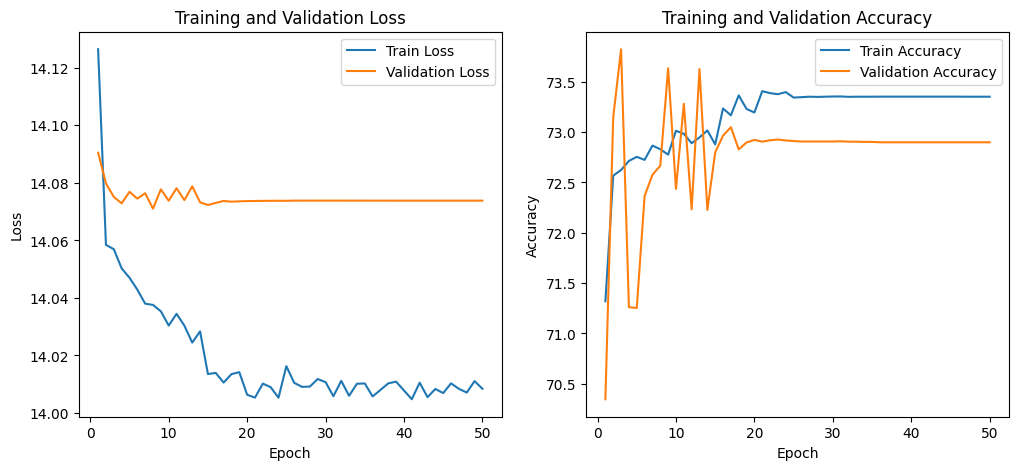

In [ ]:
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
functions.evaluate_MLP(model, X_test_tensor, Y_test_tensor, device)

# Confusion Matrix
predicted_labels = (model.forward(X_test_tensor.to(device)).detach().cpu() > 0.5).int().squeeze()

cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)

tensor([[ 1.1525,  1.1662,  0.1965,  ..., -0.9968, -0.0481,  0.9401],
        [ 1.1525, -0.8575,  0.1965,  ...,  0.6428, -2.0732, -0.9889],
        [-0.8677, -0.8575,  0.1965,  ..., -0.9968, -0.0481,  0.9401],
        ...,
        [-0.8677, -0.8575,  0.1965,  ..., -2.3084, -0.0481,  0.9401],
        [ 1.1525, -0.8575,  0.1965,  ...,  1.2986,  0.9644, -0.5066],
        [-0.8677, -0.8575,  0.1965,  ..., -0.3410,  0.9644,  0.4578]])
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\miniconda3\envs\spyder-env\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\joshu\AppData\Local\Temp\ipykernel_22492\994116120.py", line 4, in <module>
    functions.evaluate_MLP(model, X_test_tensor, Y_test_tensor)
  File "d:\IMT\3A\MCE\Intro ML\Intro-ML-Mini-Project\functions.py", line 353, in evaluate_MLP
    predicted_y = (model.forward(X_test).detach().cpu() > 0.5).numpy()
                   ^^^^^^^^^^^^^^^^^^^^^
  File "d:\IMT\3A\MCE\Intro ML\Intro-ML-Mini-Project\functions.py", line 166, in forward
    y_pred = self.L_stack(x)
             ^^^^^^^^^^^^^^^
  File "d:\miniconda3\envs\spyder-env\Lib\site-packages\torch\nn\modules\module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\miniconda3\envs\spyder-env\Lib\site-packages\torch\nn\modules\module.p

### Neural Net with rebalanced dataset


In [ ]:
##### We balance the dataset classes using RandomOverSampler ####

from sklearn.utils import resample

# Separate majority and minority classes in the training set
mask_min = Y_train == 1
X_min, y_min = X_train[mask_min], Y_train[mask_min]
X_maj, y_maj = X_train[~mask_min], Y_train[~mask_min]

# Upsample minority to match majority size
n_maj = len(y_maj)
X_min_upsampled, y_min_upsampled = resample(
    X_min, y_min,
    replace=True,
    n_samples=n_maj,
    random_state=42
)

# Combine and shuffle
X_train_balanced = np.vstack([X_maj, X_min_upsampled])
Y_train_balanced = np.hstack([y_maj, y_min_upsampled])

perm = np.random.RandomState(42).permutation(len(Y_train_balanced))
X_train_balanced = X_train_balanced[perm]
Y_train_balanced = Y_train_balanced[perm]

X_train_tensor, Y_train_tensor, X_val_tensor, Y_val_tensor, X_test_tensor, Y_test_tensor = (
    scaled_tensorize_data(
        X_train_balanced,
        Y_train_balanced,
        X_val, Y_val,
        X_test, Y_test
    )
)

In [13]:
from torch.utils.data import TensorDataset, DataLoader
import math
import os

#### Create datasets ####
train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
test_ds = TensorDataset(X_test_tensor, Y_test_tensor)

#### Create dataloaders ####
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=True, num_workers=0)
val_loader   = DataLoader(test_ds,   batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Initialize the model ####
input_size = X_train.shape[1]
hidden1_size = 32
output_size = 1

model = functions.initialize_MLP(input_size, hidden1_size, output_size)

model = model.to(device)

##### Define loss function and optimizer ####

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

scheduler_type = 'plateau'  # 'step' or 'cosine' or 'plateau' or None

In [14]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs,
    scheduler_type=scheduler_type,
    print_every_epochs=5
)

c:\Users\alexd\Github\Intro-ML-Mini-Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Epoch   1/50] LR 1.000e-03 | Train loss 53.1062  Train acc 74.84% | Val loss 14.1065  Val acc 66.83%
[Epoch   5/50] LR 1.000e-03 | Train loss 52.9922  Train acc 75.59% | Val loss 14.1004  Val acc 67.28%
[Epoch  10/50] LR 1.000e-04 | Train loss 52.9557  Train acc 76.02% | Val loss 14.0975  Val acc 67.76%
[Epoch  15/50] LR 1.000e-04 | Train loss 52.9422  Train acc 76.15% | Val loss 14.0991  Val acc 67.72%
[Epoch  20/50] LR 1.000e-05 | Train loss 52.9417  Train acc 76.18% | Val loss 14.1001  Val acc 67.66%
[Epoch  25/50] LR 1.000e-06 | Train loss 52.9477  Train acc 76.20% | Val loss 14.1005  Val acc 67.63%
[Epoch  30/50] LR 1.000e-07 | Train loss 52.9378  Train acc 76.20% | Val loss 14.1005  Val acc 67.63%
[Epoch  35/50] LR 1.000e-08 | Train loss 52.9449  Train acc 76.20% | Val loss 14.1005  Val acc 67.63%
[Epoch  40/50] LR 1.000e-08 | Train loss 52.9433  Train acc 76.20% | Val loss 14.1005  Val acc 67.63%
[Epoch  45/50] LR 1.000e-08 | Train loss 52.9385  Train acc 76.20% | Val loss 14.1

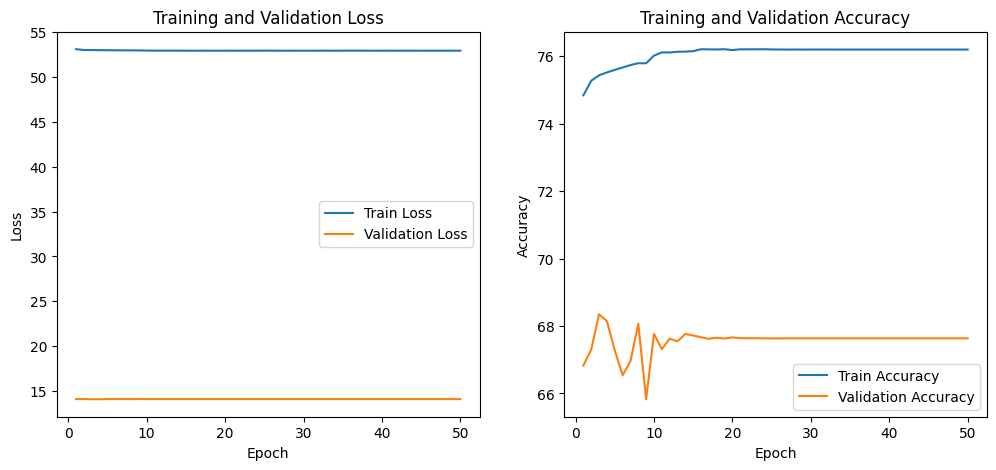

In [15]:
# Plot training/validation loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["train_loss"], label="Train Loss")
plt.plot(history["epoch"], history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["train_acc"], label="Train Accuracy")
plt.plot(history["epoch"], history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
functions.evaluate_MLP(model, X_test_tensor, Y_test_tensor, device)

# Confusion Matrix
predicted_labels = (model.forward(X_test_tensor.to(device)).detach().cpu() > 0.5).int().squeeze()

cm = confusion_matrix(Y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(Y_test, predicted_labels)
print("Classification Report:\n", cr)